In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import re
from collections import Counter
import os

# Set plotting style and directory
plt.style.use('ggplot')
sns.set_palette("colorblind")
os.makedirs('figures', exist_ok=True)

In [11]:
#########################################################
# PART 1: DATA LOADING AND PREPROCESSING

#The analysis begins by loading and merging the article and model datasets using the DOI as the primary key. The preprocessing includes:
  # - Data cleaning: Handling missing values, converting categorical fields, and addressing negative values in confidence intervals (which appear to be coding for missing data using -99)
  # - New indicator variables: Creating flags for demographic groups based on the 'compare' column:
    # - Black/African American comparisons
    # - Hispanic/Latino comparisons
    # - Asian/Pacific Islander comparisons
    # - Indigenous/Native American comparisons
    # - Missing data analysis: Visualizing patterns using missingno plots and determining whether imputation is appropriate
#########################################################

def load_data(article_path, model_path):
    """
    Load article and model datasets
    """
    print("Loading datasets...")
    article_df = pd.read_csv("article_dat.csv")
    model_df = pd.read_csv("model_dat.csv")

    print(f"Article dataset shape: {article_df.shape}")
    print(f"Model dataset shape: {model_df.shape}")

    return article_df, model_df

def explore_data(article_df, model_df):
    """
    Explore the raw datasets and report key insights
    """
    print("\n--- Data Exploration ---")

    # Explore article data
    print("\nArticle data - column types:")
    print(article_df.dtypes.value_counts())

    # Check health outcome-related columns
    health_cols = [col for col in article_df.columns if 'health' in col or 'cancer' in col or
                  'endo' in col or 'fibroid' in col or 'fert' in col or 'matmorb' in col]

    print(f"\nHealth outcome columns: {health_cols}")

    health_counts = {}
    for col in health_cols:
        health_counts[col] = article_df[col].value_counts().get(1, 0)

    print("Health outcome counts:")
    for col, count in sorted(health_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  {col}: {count}")

    # Explore healthcare access and treatment columns
    access_cols = ['access_to_care', 'treatment_received']

    print("\nHealthcare access and treatment columns:")
    for col in access_cols:
        print(f"  {col}: {article_df[col].value_counts().get(1, 0)} studies")

    # Explore model data
    print("\nModel data:")
    print(f"  Number of unique effect size measures: {model_df['measure'].nunique()}")
    print(f"  Most common effect size measures: {model_df['measure'].value_counts().head(5).to_dict()}")

    # Check effect size columns
    effect_cols = ['point', 'lower', 'upper']
    print("\nEffect size columns - missing values:")
    for col in effect_cols:
        missing = model_df[col].isnull().sum()
        print(f"  {col}: {missing} missing values ({missing/len(model_df)*100:.2f}%)")

    # Check negative values in confidence intervals (potential data coding issue)
    for col in ['lower', 'upper']:
        neg_values = (model_df[col] < 0).sum()
        print(f"  {col}: {neg_values} negative values ({neg_values/len(model_df)*100:.2f}%)")

    return None

def merge_datasets(article_df, model_df):
    """
    Merge article and model datasets on DOI
    """
    print("\n--- Merging Datasets ---")

    # Merge on DOI
    merged_df = pd.merge(model_df, article_df, on='doi', how='left')
    print(f"Merged dataset shape: {merged_df.shape}")

    # Check if merge was successful
    if len(merged_df) == len(model_df):
        print("All model records successfully matched with article data")
    else:
        print(f"Warning: {len(model_df) - len(merged_df)} model records couldn't be matched")

    return merged_df

def clean_data(merged_df):
    """
    Clean and prepare the merged dataset for analysis
    """
    print("\n--- Cleaning Data ---")

    # Make a copy to avoid modifying the original
    clean_df = merged_df.copy()

    # Handle negative values in confidence intervals (typically -99 is used as missing)
    for col in ['lower', 'upper']:
        neg_count = (clean_df[col] < 0).sum()
        if neg_count > 0:
            print(f"  Replacing {neg_count} negative values in {col} with NaN")
            clean_df.loc[clean_df[col] < 0, col] = np.nan

    # Handle 'NA' strings
    for col in clean_df.select_dtypes(include=['object']).columns:
        na_count = (clean_df[col] == 'NA').sum()
        if na_count > 0:
            print(f"  Replacing {na_count} 'NA' strings in {col} with NaN")
            clean_df[col] = clean_df[col].replace('NA', np.nan)

    # Create flags for health outcome-related columns
    print("  Creating health outcome indicator variables")

    # 1. Main indicators
    for col in ['health_outcome', 'access_to_care', 'treatment_received']:
        if col in clean_df.columns:
            clean_df[f'has_{col}'] = clean_df[col].apply(lambda x: 1 if x == 1 else 0)

    # 2. Race/ethnicity indicators based on 'compare' column
    print("  Creating race/ethnicity comparison indicators")

    clean_df['is_black_comparison'] = clean_df['compare'].str.contains(
        'black|Black|African', case=False, na=False).astype(int)

    clean_df['is_hispanic_comparison'] = clean_df['compare'].str.contains(
        'hispanic|latina|latino', case=False, na=False).astype(int)

    clean_df['is_asian_comparison'] = clean_df['compare'].str.contains(
        'asian|pacific', case=False, na=False).astype(int)

    clean_df['is_indigenous_comparison'] = clean_df['compare'].str.contains(
        'native|indian|indigenous|american indian|alaska', case=False, na=False).astype(int)

    # 3. Log-transform effect sizes for analysis
    clean_df['log_point'] = np.log(clean_df['point'])

    return clean_df

def analyze_missing_data(df):
    """
    Analyze missing data patterns in the dataset
    """
    print("\n--- Missing Data Analysis ---")

    # Calculate missing data percentages
    missing_data = df.isnull().mean().sort_values(ascending=False) * 100
    print("Columns with highest percentage of missing values:")
    print(missing_data[missing_data > 0].head(10))

    # Visualize missing data patterns
    plt.figure(figsize=(10, 6))
    msno.matrix(df.sample(min(1000, len(df))), figsize=(10, 6))
    plt.title('Missing Data Matrix (Sample)')
    plt.tight_layout()
    plt.savefig('figures/missing_data_matrix.png')

    plt.figure(figsize=(10, 6))
    msno.bar(df, figsize=(10, 6))
    plt.title('Missing Data by Column')
    plt.tight_layout()
    plt.savefig('figures/missing_data_bar.png')

    # Check if imputation is needed
    effect_cols = ['point', 'lower', 'upper']
    missing_pct = df[effect_cols].isnull().mean() * 100
    print(f"\nMissing data in effect size columns: {missing_pct.to_dict()}")

    if missing_pct.max() < 20:
        print("Missing data percentage is below 20%, imputation can be applied")
        return True
    else:
        print("High percentage of missing data, analysis will proceed with complete cases only")
        return False

def impute_missing_data(df, columns_to_impute):
    """
    Impute missing values using KNN imputation
    """
    print("\n--- Imputing Missing Data ---")

    # Create imputer
    imputer = KNNImputer(n_neighbors=5)

    # Get subset of data for imputation
    df_to_impute = df[columns_to_impute].copy()

    # Standardize features
    scaler = StandardScaler()
    df_to_impute_scaled = pd.DataFrame(
        scaler.fit_transform(df_to_impute),
        columns=df_to_impute.columns
    )

    # Perform imputation
    print(f"  Imputing {columns_to_impute} using KNN (k=5)")
    df_imputed_scaled = pd.DataFrame(
        imputer.fit_transform(df_to_impute_scaled),
        columns=df_to_impute.columns
    )

    # Reverse scaling
    df_imputed = pd.DataFrame(
        scaler.inverse_transform(df_imputed_scaled),
        columns=df_to_impute.columns
    )

    # Create output dataframe
    result_df = df.copy()
    result_df[columns_to_impute] = df_imputed

    # Report results
    for col in columns_to_impute:
        before = df[col].isnull().sum()
        after = result_df[col].isnull().sum()
        print(f"  {col}: {before} missing values before, {after} missing values after imputation")

    return result_df

def create_analysis_dataset(clean_df):
    """
    Create datasets for health outcome analysis
    """
    print("\n--- Creating Analysis Datasets ---")

    # Create health outcome dataset
    health_outcome_df = clean_df[clean_df['health_outcome'] == 1].copy()
    print(f"Health outcome dataset: {health_outcome_df.shape[0]} records")

    # Create dataset for access to care analysis
    access_df = clean_df[clean_df['access_to_care'] == 1].copy()
    print(f"Access to care dataset: {access_df.shape[0]} records")

    # Create dataset for treatment received analysis
    treatment_df = clean_df[clean_df['treatment_received'] == 1].copy()
    print(f"Treatment received dataset: {treatment_df.shape[0]} records")

    # Create dataset for both access and treatment
    access_treatment_df = clean_df[(clean_df['access_to_care'] == 1) &
                                 (clean_df['treatment_received'] == 1)].copy()
    print(f"Access and treatment dataset: {access_treatment_df.shape[0]} records")

    return health_outcome_df, access_df, treatment_df, access_treatment_df

=== HEALTH DISPARITIES FACTOR ANALYSIS ===
Question 2: What factors influence health outcomes across studies?
Loading datasets...
Article dataset shape: (318, 65)
Model dataset shape: (6804, 16)

--- Data Exploration ---

Article data - column types:
float64    37
object     24
int64       4
Name: count, dtype: int64

Health outcome columns: ['health_outcome', 'cancer_ovarian', 'cancer_uterine', 'cancer_cervical', 'cancer_vulvar', 'endo', 'fibroids', 'fert', 'matmorbmort']
Health outcome counts:
  health_outcome: 239
  matmorbmort: 94
  cancer_uterine: 69
  cancer_ovarian: 50
  fert: 31
  cancer_cervical: 28
  cancer_vulvar: 10
  fibroids: 8
  endo: 2

Healthcare access and treatment columns:
  access_to_care: 119 studies
  treatment_received: 184 studies

Model data:
  Number of unique effect size measures: 83
  Most common effect size measures: {'OR': 1975, 'Percent': 1370, 'RR': 1200, 'HR': 679, 'Incidence': 225}

Effect size columns - missing values:
  point: 36 missing values (0.5

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-11-104406f1556c>:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Missing data in effect size columns: {'point': 0.5291005291005291, 'lower': 34.038800705467374, 'upper': 33.50970017636684}
High percentage of missing data, analysis will proceed with complete cases only

--- Creating Analysis Datasets ---
Health outcome dataset: 5212 records
Access to care dataset: 3022 records
Treatment received dataset: 3438 records
Access and treatment dataset: 1894 records

--- Health Outcome Distributions ---
Number of unique outcomes: 741
Top 10 most common outcomes:
outcome
Primary cesarean delivery                                          171
severe maternal morbidity                                          103
preterm birth                                                       76
Ectopic Pregnancy                                                   66
endometrial cancer 5-year survival                                  64
endometrial cancer 2-year survival                                  64
Seeking treatment for urinary incontinence in visits 7, 8, or 9     5

<Figure size 1000x600 with 0 Axes>

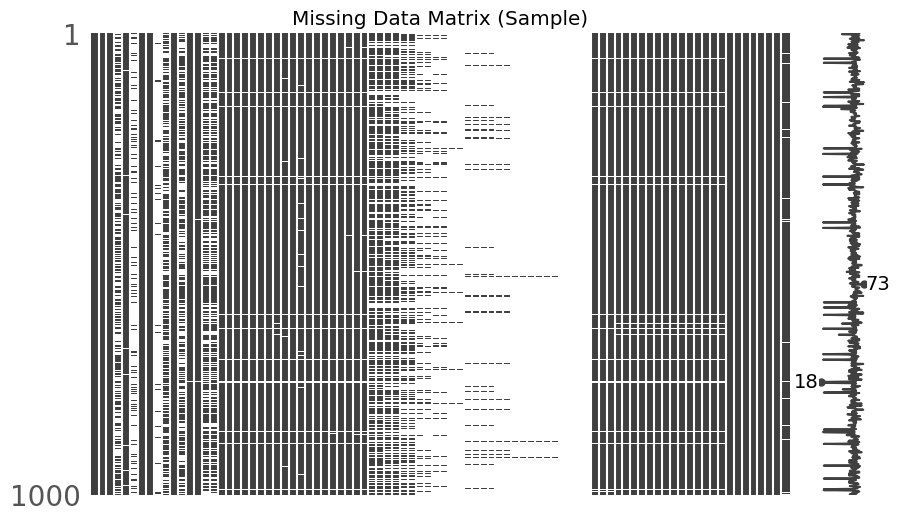

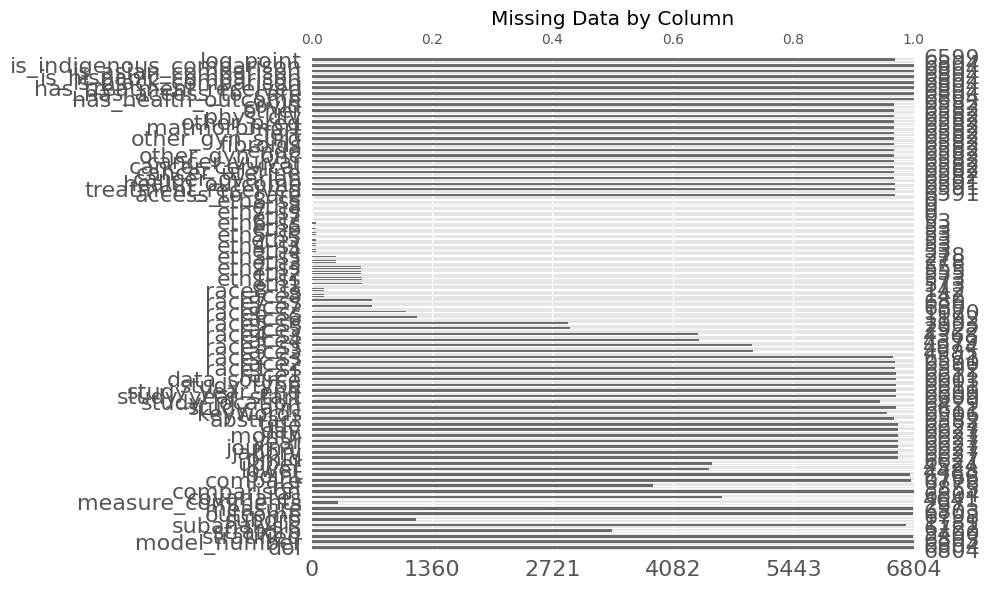

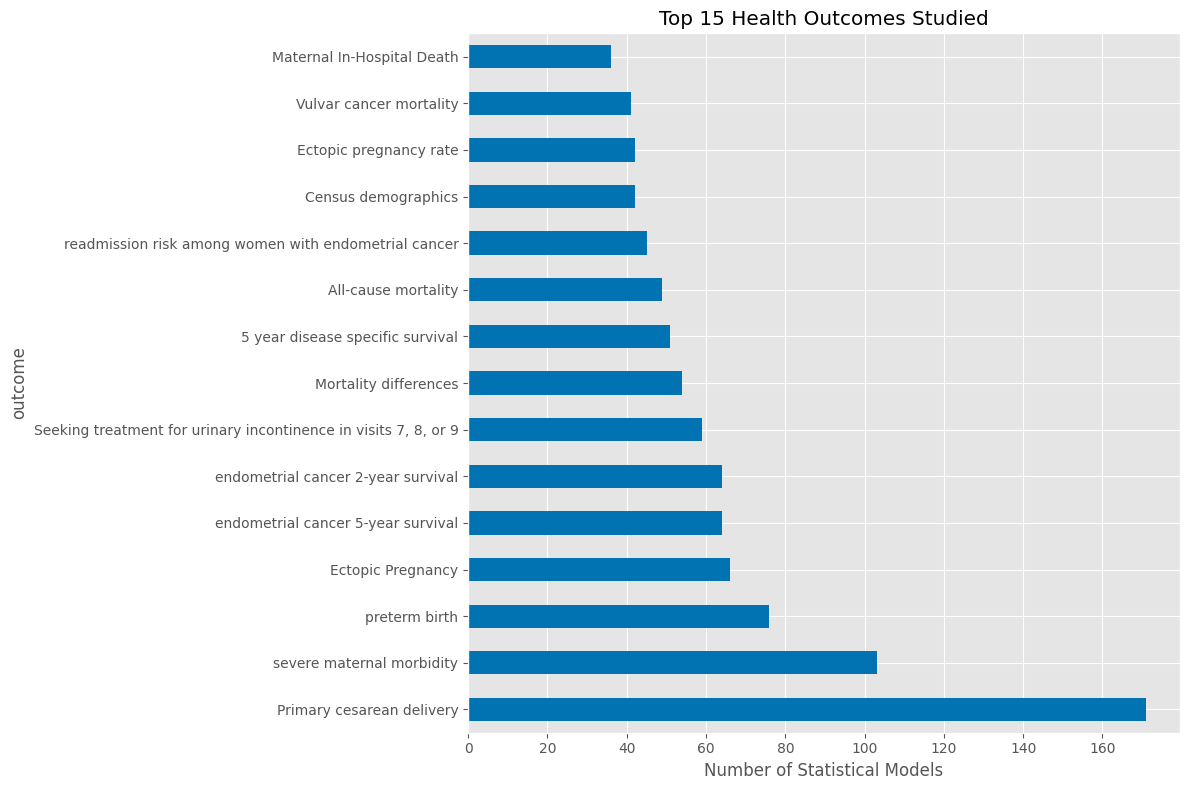

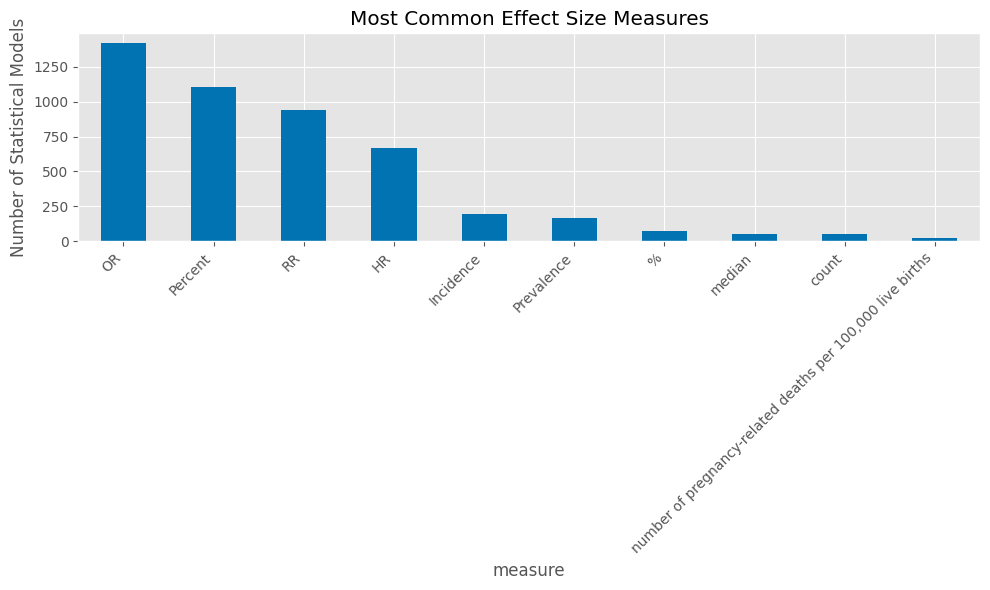

<Figure size 1600x1200 with 0 Axes>

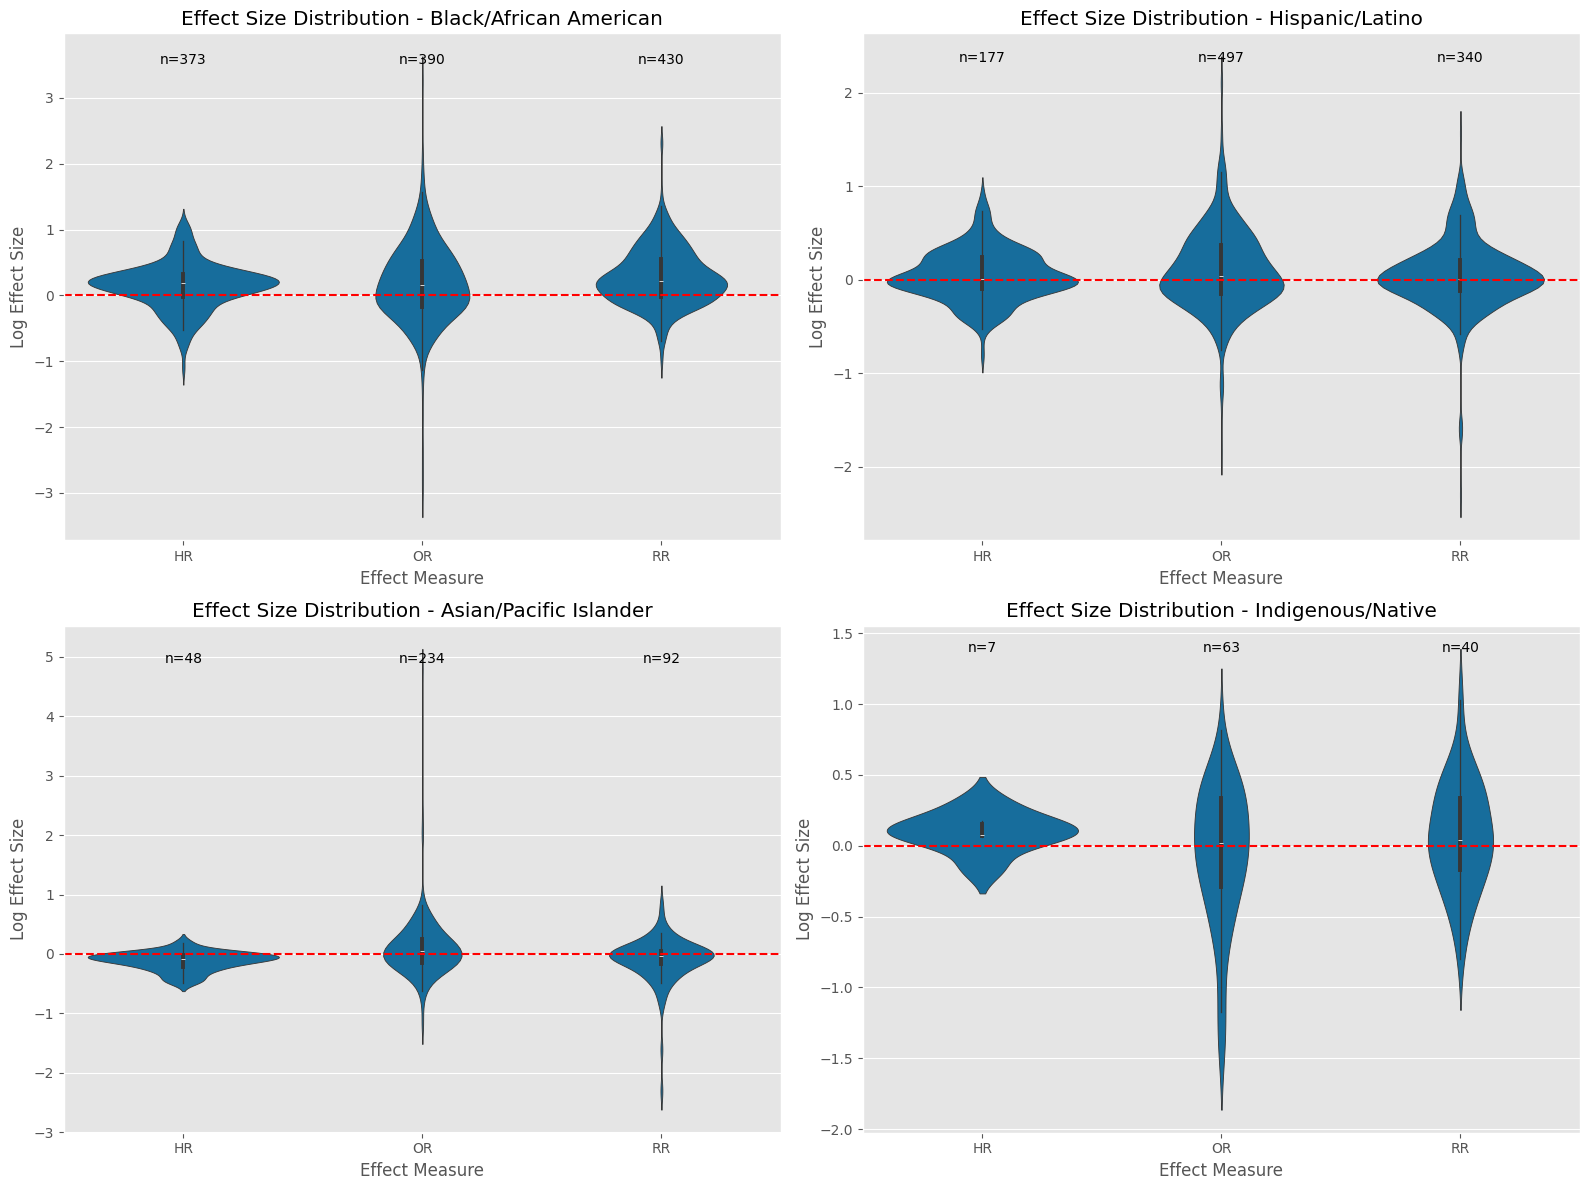

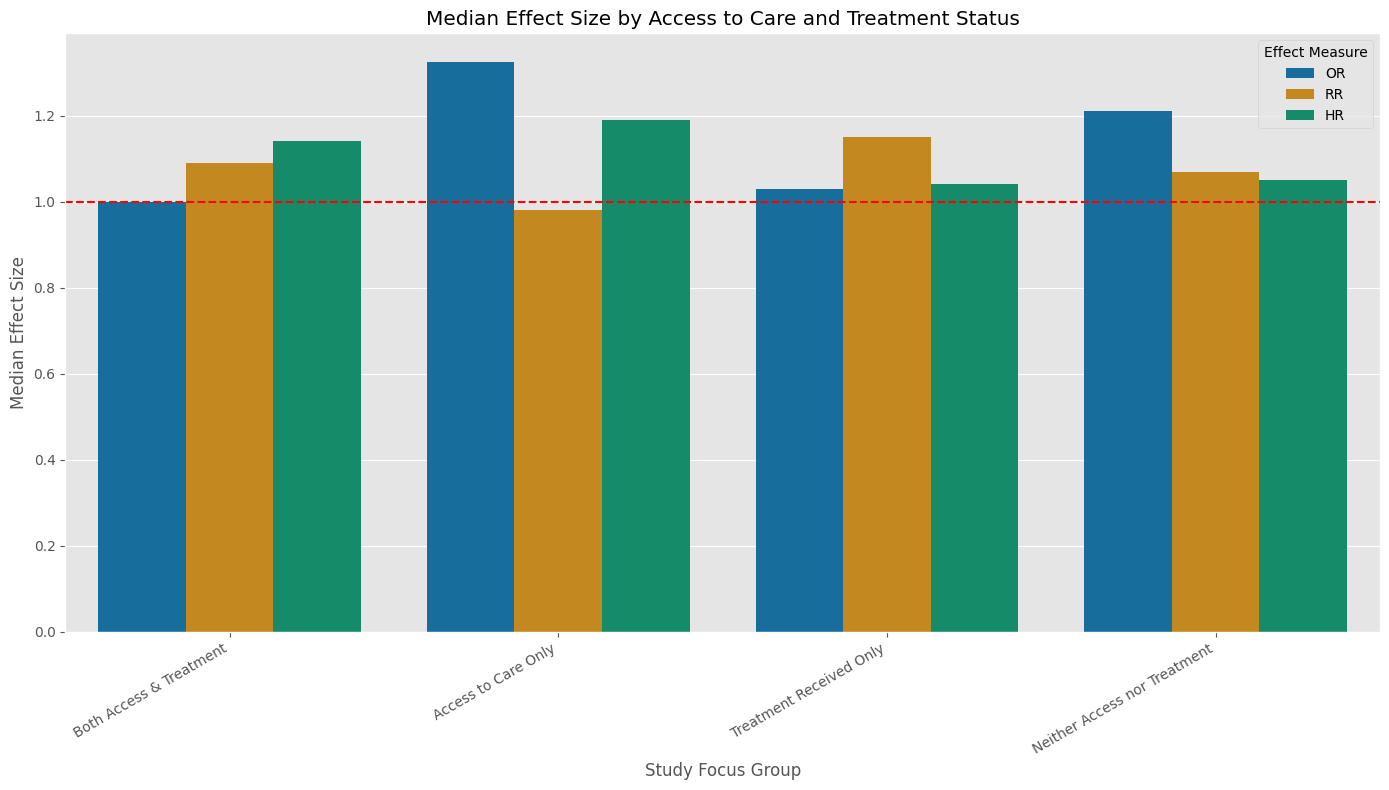

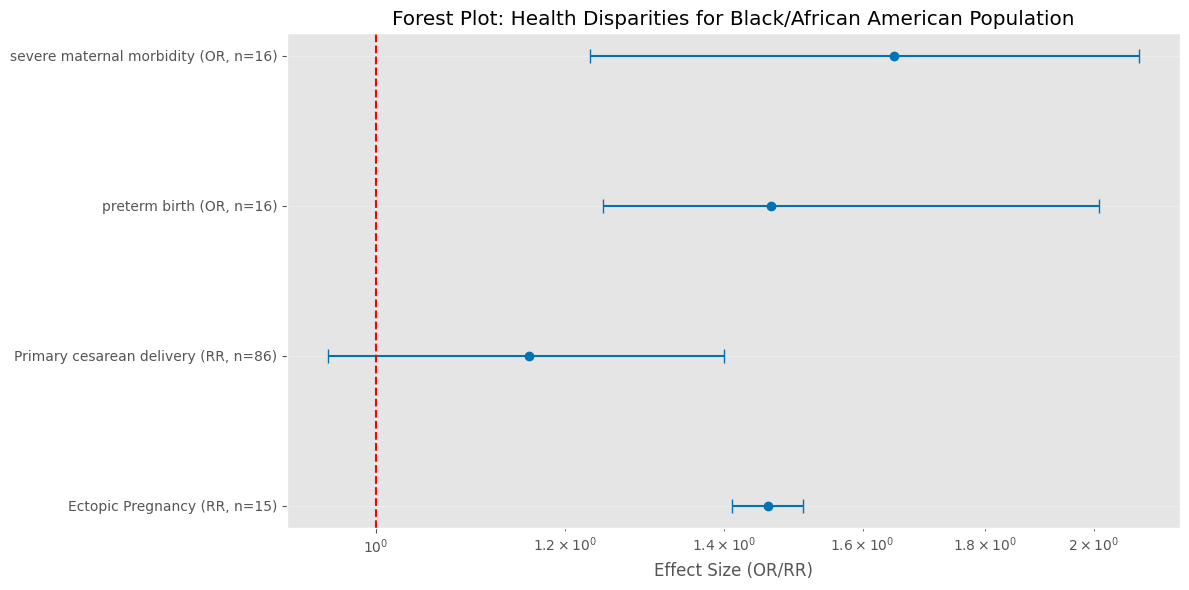

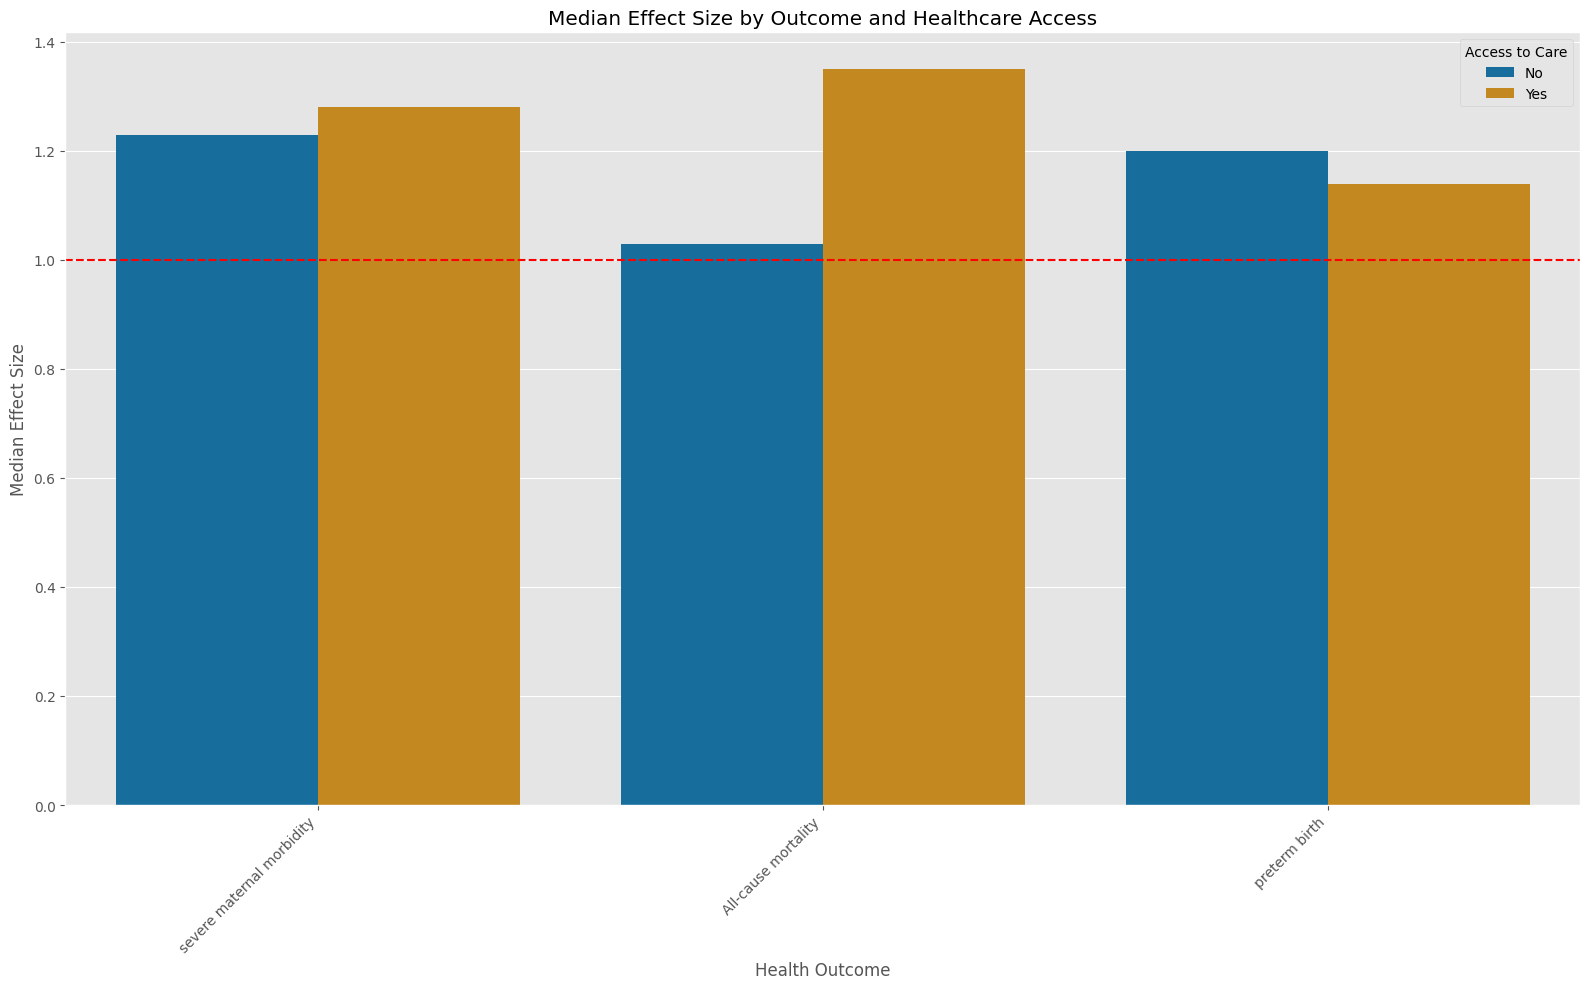

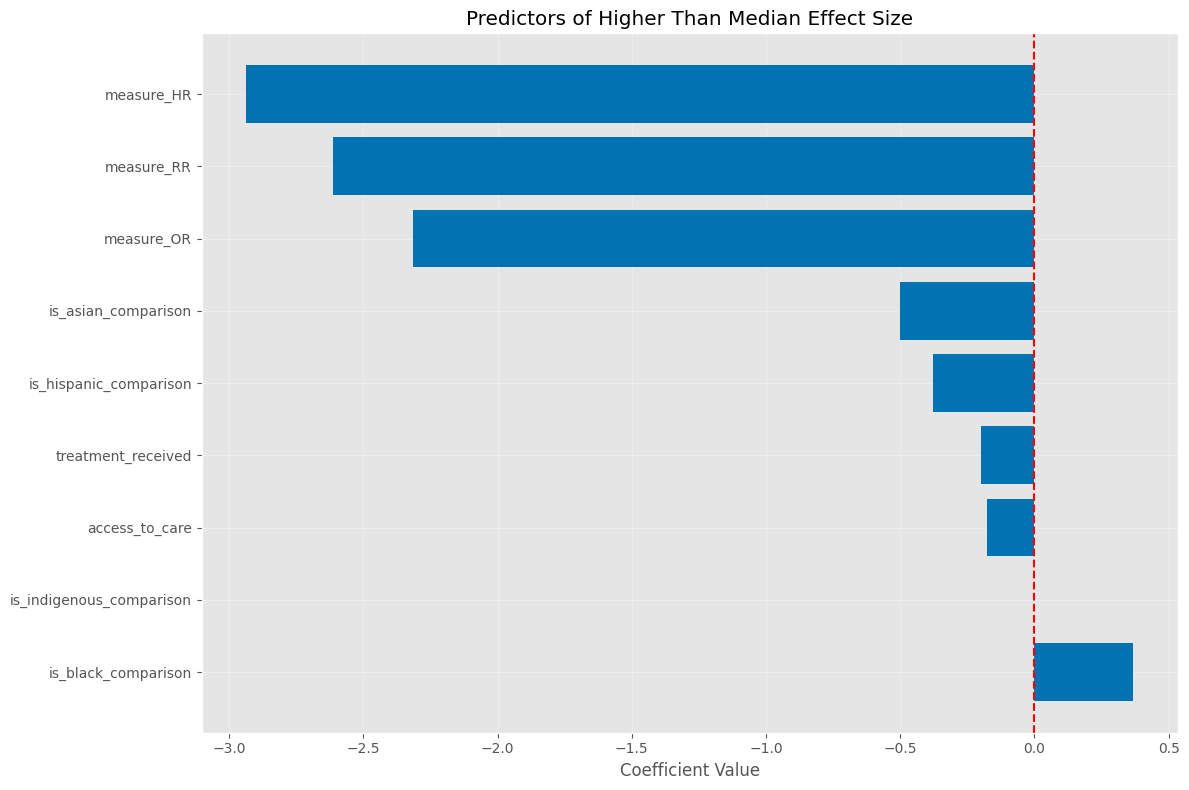

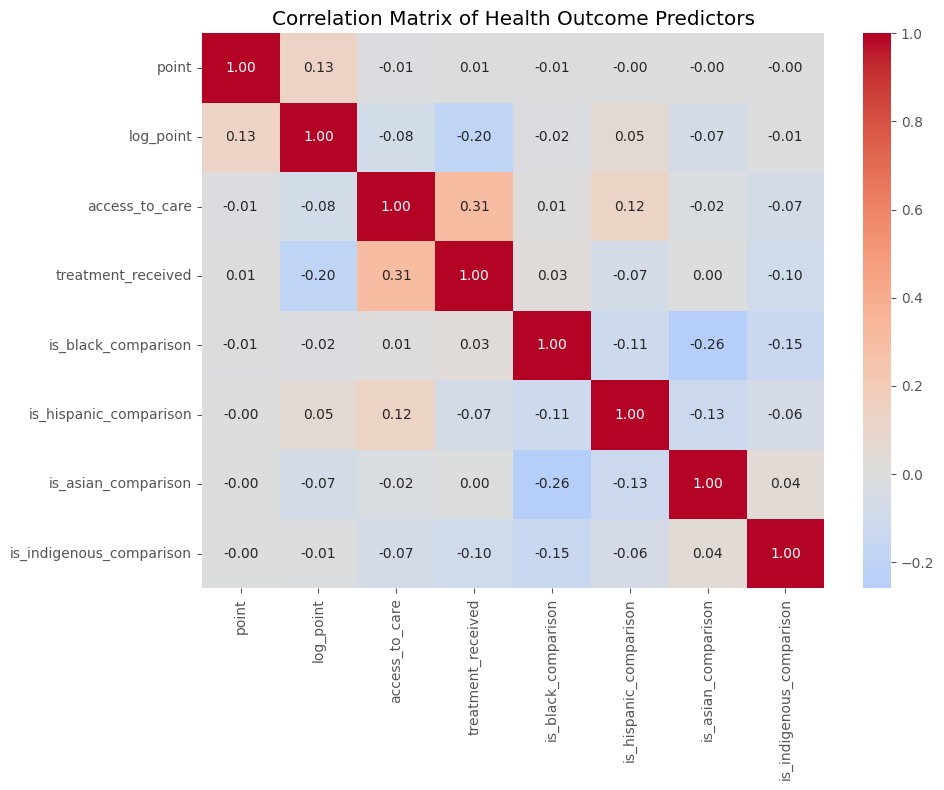

In [12]:
#########################################################
# PART 2: ANALYZING FACTORS INFLUENCING HEALTH OUTCOMES
#########################################################

def analyze_outcome_distributions(health_outcome_df):
    """
    Analyze the distribution of health outcomes in the dataset
    """
    print("\n--- Health Outcome Distributions ---")

    # Count models by outcome
    outcome_counts = health_outcome_df['outcome'].value_counts()
    print(f"Number of unique outcomes: {len(outcome_counts)}")
    print("Top 10 most common outcomes:")
    print(outcome_counts.head(10))

    # Visualize top outcomes
    plt.figure(figsize=(12, 8))
    outcome_counts.head(15).plot(kind='barh')
    plt.title('Top 15 Health Outcomes Studied')
    plt.xlabel('Number of Statistical Models')
    plt.tight_layout()
    plt.savefig('figures/top_health_outcomes.png')

    # Count by effect size measure
    measure_counts = health_outcome_df['measure'].value_counts()
    print("\nMost common effect size measures:")
    print(measure_counts.head(10))

    # Visualize measures
    plt.figure(figsize=(10, 6))
    measure_counts.head(10).plot(kind='bar')
    plt.title('Most Common Effect Size Measures')
    plt.ylabel('Number of Statistical Models')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('figures/effect_size_measures.png')

    return outcome_counts, measure_counts

def analyze_effect_sizes_by_demographics(health_outcome_df):
    """
    Analyze effect sizes by demographic groups
    """
    print("\n--- Effect Sizes by Demographics ---")

    # Filter for common effect size measures
    common_measures = ['OR', 'RR', 'HR']
    effect_df = health_outcome_df[health_outcome_df['measure'].isin(common_measures)].copy()

    # Define demographic groups
    demo_groups = [
        ('is_black_comparison', 'Black/African American'),
        ('is_hispanic_comparison', 'Hispanic/Latino'),
        ('is_asian_comparison', 'Asian/Pacific Islander'),
        ('is_indigenous_comparison', 'Indigenous/Native')
    ]

    # Calculate summary statistics by group and measure
    print("Effect size statistics by demographic group:")

    for group_col, group_name in demo_groups:
        group_data = effect_df[effect_df[group_col] == 1]

        if len(group_data) > 0:
            print(f"\n{group_name} (n={len(group_data)}):")

            for measure in common_measures:
                measure_data = group_data[group_data['measure'] == measure]

                if len(measure_data) > 0:
                    stats_dict = {
                        'count': len(measure_data),
                        'mean': measure_data['point'].mean(),
                        'median': measure_data['point'].median(),
                        'min': measure_data['point'].min(),
                        'max': measure_data['point'].max(),
                        'above_1': (measure_data['point'] > 1).mean() * 100  # % of effects > 1
                    }

                    print(f"  {measure} (n={stats_dict['count']}):")
                    print(f"    Mean: {stats_dict['mean']:.2f}, Median: {stats_dict['median']:.2f}")
                    print(f"    Range: {stats_dict['min']:.2f} to {stats_dict['max']:.2f}")
                    print(f"    % with worse outcomes: {stats_dict['above_1']:.1f}%")

    # Create violin plots
    plt.figure(figsize=(16, 12))
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for i, (group_col, group_name) in enumerate(demo_groups):
        group_data = effect_df[effect_df[group_col] == 1]

        if len(group_data) > 0:
            # Plot on log scale for better visualization
            sns.violinplot(x='measure', y='log_point', data=group_data, ax=axes[i])

            # Add reference line at log(1) = 0
            axes[i].axhline(y=0, color='r', linestyle='--')

            # Set labels
            axes[i].set_title(f'Effect Size Distribution - {group_name}')
            axes[i].set_ylabel('Log Effect Size')
            axes[i].set_xlabel('Effect Measure')

            # Add sample sizes
            for j, measure in enumerate(group_data['measure'].unique()):
                measure_count = len(group_data[group_data['measure'] == measure])
                axes[i].text(j, axes[i].get_ylim()[1] * 0.9, f'n={measure_count}',
                           ha='center', va='center')

    plt.tight_layout()
    plt.savefig('figures/effect_sizes_by_race.png')

    return effect_df

def analyze_healthcare_access_treatment(health_outcome_df):
    """
    Analyze how healthcare access and treatment received impact effect sizes
    """
    print("\n--- Healthcare Access and Treatment Analysis ---")

    # Common effect size measures
    common_measures = ['OR', 'RR', 'HR']

    # Create access/treatment groups
    access_treatment_groups = [
        (1, 1, 'Both Access & Treatment'),
        (1, 0, 'Access to Care Only'),
        (0, 1, 'Treatment Received Only'),
        (0, 0, 'Neither Access nor Treatment')
    ]

    # Calculate statistics by group
    results = []

    for access, treatment, label in access_treatment_groups:
        # Filter data
        group_data = health_outcome_df[
            (health_outcome_df['access_to_care'] == access) &
            (health_outcome_df['treatment_received'] == treatment)
        ]

        # Calculate statistics for common measures
        if len(group_data) > 0:
            for measure in common_measures:
                measure_data = group_data[group_data['measure'] == measure]

                if len(measure_data) > 0:
                    stats_dict = {
                        'Group': label,
                        'Measure': measure,
                        'Count': len(measure_data),
                        'Mean': measure_data['point'].mean(),
                        'Median': measure_data['point'].median(),
                        'Above_1_pct': (measure_data['point'] > 1).mean() * 100
                    }

                    results.append(stats_dict)

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Display results
    if not results_df.empty:
        print("\nEffect size statistics by access and treatment status:")
        for group in results_df['Group'].unique():
            group_data = results_df[results_df['Group'] == group]
            print(f"\n{group}:")
            for _, row in group_data.iterrows():
                print(f"  {row['Measure']} (n={row['Count']}): Mean={row['Mean']:.2f}, Median={row['Median']:.2f}, % above 1={row['Above_1_pct']:.1f}%")

    # Create visualization
    plt.figure(figsize=(14, 8))

    # Plot median effects by group and measure
    if not results_df.empty:
        sns.barplot(x='Group', y='Median', hue='Measure', data=results_df)

        plt.title('Median Effect Size by Access to Care and Treatment Status')
        plt.xlabel('Study Focus Group')
        plt.ylabel('Median Effect Size')
        plt.axhline(y=1, color='r', linestyle='--')  # Line at 1 (no effect)
        plt.legend(title='Effect Measure')
        plt.xticks(rotation=30, ha='right')
        plt.tight_layout()
        plt.savefig('figures/effect_by_access_treatment.png')

    return results_df

def create_forest_plot(health_outcome_df, race_group='is_black_comparison'):
    """
    Create a forest plot for health disparities among specific racial/ethnic groups
    """
    print("\n--- Forest Plot for Health Disparities ---")

    # Filter for common effect size measures
    common_measures = ['OR', 'RR']
    effect_df = health_outcome_df[health_outcome_df['measure'].isin(common_measures)].copy()

    # Identify top health outcomes
    top_outcomes = health_outcome_df['outcome'].value_counts().head(5).index.tolist()

    # Get selected race/ethnicity group name
    race_group_names = {
        'is_black_comparison': 'Black/African American',
        'is_hispanic_comparison': 'Hispanic/Latino',
        'is_asian_comparison': 'Asian/Pacific Islander',
        'is_indigenous_comparison': 'Indigenous/Native'
    }
    race_name = race_group_names.get(race_group, race_group)

    # Filter for racial/ethnic comparisons and top outcomes
    forest_data = effect_df[
        (effect_df[race_group] == 1) &
        (effect_df['outcome'].isin(top_outcomes)) &
        (~effect_df['point'].isnull()) &
        (~effect_df['lower'].isnull()) &
        (~effect_df['upper'].isnull())
    ].copy()

    if len(forest_data) > 0:
        # Group by outcome and measure
        forest_stats = []

        for outcome in top_outcomes:
            for measure in common_measures:
                outcome_data = forest_data[
                    (forest_data['outcome'] == outcome) &
                    (forest_data['measure'] == measure)
                ]

                if len(outcome_data) >= 3:  # Require at least 3 studies
                    stats_dict = {
                        'Outcome': outcome,
                        'Measure': measure,
                        'Count': len(outcome_data),
                        'Point': outcome_data['point'].median(),
                        'Lower': outcome_data['lower'].median(),
                        'Upper': outcome_data['upper'].median()
                    }
                    forest_stats.append(stats_dict)

        if forest_stats:
            # Convert to DataFrame and sort
            forest_df = pd.DataFrame(forest_stats)
            forest_df = forest_df.sort_values(['Outcome', 'Measure', 'Point'])

            # Create forest plot
            plt.figure(figsize=(12, len(forest_df) + 2))

            # Plot points with error bars
            y_pos = np.arange(len(forest_df))
            plt.errorbar(
                x=forest_df['Point'],
                y=y_pos,
                xerr=[forest_df['Point'] - forest_df['Lower'], forest_df['Upper'] - forest_df['Point']],
                fmt='o',
                capsize=5
            )

            # Add outcome labels
            plt.yticks(y_pos, forest_df['Outcome'] + ' (' + forest_df['Measure'] + ', n=' + forest_df['Count'].astype(str) + ')')

            # Add reference line
            plt.axvline(x=1, color='r', linestyle='--')

            # Set x-axis to log scale
            plt.xscale('log')

            # Add labels and title
            plt.xlabel('Effect Size (OR/RR)')
            plt.title(f'Forest Plot: Health Disparities for {race_name} Population')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(f'figures/health_disparities_forest_plot_{race_group}.png')

            print(f"Created forest plot for {race_name} population with {len(forest_df)} outcome-measure combinations")
            print("Effect sizes by outcome:")
            for _, row in forest_df.iterrows():
                print(f"  {row['Outcome']} ({row['Measure']}, n={row['Count']}): {row['Point']:.2f} [{row['Lower']:.2f}, {row['Upper']:.2f}]")

            return forest_df
        else:
            print(f"Insufficient data to create forest plot for {race_name} population")
            return None
    else:
        print(f"Insufficient data to create forest plot for {race_name} population")
        return None

def analyze_healthcare_access_outcomes(health_outcome_df):
    """
    Analyze correlation between healthcare access and outcomes
    """
    print("\n--- Healthcare Access and Outcomes Analysis ---")

    # Filter for common measures
    common_measures = ['OR', 'RR', 'HR']
    effect_df = health_outcome_df[health_outcome_df['measure'].isin(common_measures)].copy()

    # Create healthcare access indicator
    effect_df['has_healthcare_access'] = (effect_df['access_to_care'] == 1).astype(int)

    # Identify top outcomes
    top_outcomes = effect_df['outcome'].value_counts().head(10).index.tolist()

    # Calculate statistics by outcome and access
    access_outcome_stats = []

    for outcome in top_outcomes:
        outcome_data = effect_df[effect_df['outcome'] == outcome]

        for has_access in [0, 1]:
            access_data = outcome_data[outcome_data['has_healthcare_access'] == has_access]

            if len(access_data) >= 5:  # Require at least 5 studies
                for measure in common_measures:
                    measure_data = access_data[access_data['measure'] == measure]

                    if len(measure_data) >= 3:  # Require at least 3 studies for this measure
                        stats_dict = {
                            'Outcome': outcome,
                            'Access': 'Yes' if has_access == 1 else 'No',
                            'Measure': measure,
                            'Count': len(measure_data),
                            'Mean': measure_data['point'].mean(),
                            'Median': measure_data['point'].median(),
                            'Above_1_pct': (measure_data['point'] > 1).mean() * 100
                        }

                        access_outcome_stats.append(stats_dict)

    # Convert to DataFrame
    if access_outcome_stats:
        access_df = pd.DataFrame(access_outcome_stats)

        print("Healthcare access and outcome statistics:")
        for outcome in access_df['Outcome'].unique():
            outcome_data = access_df[access_df['Outcome'] == outcome]

            # Check if we have both access categories
            if set(outcome_data['Access']) == {'Yes', 'No'}:
                print(f"\n{outcome}:")

                for access in ['Yes', 'No']:
                    access_rows = outcome_data[outcome_data['Access'] == access]
                    for _, row in access_rows.iterrows():
                        print(f"  Access = {access}, {row['Measure']} (n={row['Count']}): Mean={row['Mean']:.2f}, Median={row['Median']:.2f}")

        # Create visualization
        plt.figure(figsize=(16, 10))

        # Filter outcomes with both access categories
        outcomes_with_both = []
        for outcome in access_df['Outcome'].unique():
            access_values = access_df[access_df['Outcome'] == outcome]['Access'].unique()
            if 'Yes' in access_values and 'No' in access_values:
                outcomes_with_both.append(outcome)

        if outcomes_with_both:
            # Filter and plot
            plot_df = access_df[access_df['Outcome'].isin(outcomes_with_both[:5])]  # Limit to 5 outcomes

            sns.barplot(x='Outcome', y='Median', hue='Access', data=plot_df)

            plt.title('Median Effect Size by Outcome and Healthcare Access')
            plt.xlabel('Health Outcome')
            plt.ylabel('Median Effect Size')
            plt.axhline(y=1, color='r', linestyle='--')  # Line at 1 (no effect)
            plt.legend(title='Access to Care')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig('figures/effect_by_outcome_access.png')

            return access_df
        else:
            print("No outcomes with both access categories found")
            return None
    else:
        print("Insufficient data for healthcare access and outcomes analysis")
        return None

def perform_predictive_modeling(health_outcome_df):
    """
    Perform predictive modeling to identify key predictors of health outcomes
    """
    print("\n--- Predictive Modeling ---")

    # Check if we have enough data
    complete_cases = health_outcome_df.dropna(subset=['point', 'health_outcome',
                                                    'access_to_care', 'treatment_received'])

    print(f"Complete cases available for modeling: {len(complete_cases)}")

    if len(complete_cases) < 500:
        print("Insufficient data for reliable predictive modeling (< 500 complete cases)")
        return None

    # Prepare data for modeling
    print("Preparing data for predictive modeling...")
    model_data = complete_cases.copy()

    # Convert effect sizes to binary outcome (above/below median)
    median_effect = model_data['point'].median()
    model_data['high_effect'] = (model_data['point'] > median_effect).astype(int)

    # Define predictors
    predictors = ['access_to_care', 'treatment_received',
                 'is_black_comparison', 'is_hispanic_comparison',
                 'is_asian_comparison', 'is_indigenous_comparison']

    # Add indicator for common measures
    common_measures = ['OR', 'RR', 'HR']
    for measure in common_measures:
        model_data[f'measure_{measure}'] = (model_data['measure'] == measure).astype(int)
        predictors.append(f'measure_{measure}')

    # Split data into features and target
    X = model_data[predictors]
    y = model_data['high_effect']

    # Fit logistic regression
    print("Fitting logistic regression model...")

    try:
        # Fit with sklearn for coefficient values
        logreg = LogisticRegression(random_state=42, max_iter=1000)
        logreg.fit(X, y)

        # Get coefficients and odds ratios
        coef_df = pd.DataFrame({
            'Predictor': X.columns,
            'Coefficient': logreg.coef_[0],
            'Odds_Ratio': np.exp(logreg.coef_[0])
        })

        # Sort by coefficient magnitude
        coef_df = coef_df.sort_values('Coefficient', ascending=False)

        print("\nLogistic Regression Results (predicting higher than median effect size):")
        print(coef_df)

        # Calculate model performance
        y_pred_prob = logreg.predict_proba(X)[:, 1]
        auc = roc_auc_score(y, y_pred_prob)
        print(f"Model AUC: {auc:.3f}")

        # Plot coefficients
        plt.figure(figsize=(12, 8))

        # Create horizontal bar chart of coefficients
        plt.barh(coef_df['Predictor'], coef_df['Coefficient'])

        # Add reference line at 0
        plt.axvline(x=0, color='r', linestyle='--')

        # Add labels and title
        plt.xlabel('Coefficient Value')
        plt.title('Predictors of Higher Than Median Effect Size')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('figures/predictor_coefficients.png')

        # Fit with statsmodels for p-values
        X_sm = sm.add_constant(X)
        logit_model = sm.Logit(y, X_sm)
        result = logit_model.fit(disp=0)

        # Print summary
        print("\nDetailed Logistic Regression Results:")
        print(result.summary())

        # Calculate and return key variable importance
        coef_df['p_value'] = result.pvalues[1:]  # Skip intercept
        coef_df['significant'] = coef_df['p_value'] < 0.05

        return coef_df

    except Exception as e:
        print(f"Error in predictive modeling: {e}")
        return None

def perform_correlation_analysis(health_outcome_df):
    """
    Analyze correlations between effect sizes and other variables
    """
    print("\n--- Correlation Analysis ---")

    # Select variables for correlation analysis
    corr_vars = ['point', 'log_point', 'access_to_care', 'treatment_received',
                'is_black_comparison', 'is_hispanic_comparison',
                'is_asian_comparison', 'is_indigenous_comparison']

    # Filter existing columns
    existing_cols = [col for col in corr_vars if col in health_outcome_df.columns]

    # Create correlation matrix
    corr_df = health_outcome_df[existing_cols].copy()
    corr_matrix = corr_df.corr()

    # Display correlation with effect size
    effect_corr = corr_matrix['point'].sort_values(ascending=False)
    log_effect_corr = corr_matrix['log_point'].sort_values(ascending=False)

    print("\nCorrelations with effect size (point):")
    print(effect_corr)

    print("\nCorrelations with log effect size:")
    print(log_effect_corr)

    # Plot correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Correlation Matrix of Health Outcome Predictors')
    plt.tight_layout()
    plt.savefig('figures/correlation_matrix.png')

    return corr_matrix

def main():
    """
    Main function to run the entire analysis pipeline
    """
    print("=== HEALTH DISPARITIES FACTOR ANALYSIS ===")
    print("Question 2: What factors influence health outcomes across studies?")

    # Set file paths
    article_path = 'article_dat.csv'
    model_path = 'model_dat.csv'

    # 1. Data loading and preprocessing
    article_df, model_df = load_data(article_path, model_path)
    explore_data(article_df, model_df)
    merged_df = merge_datasets(article_df, model_df)
    clean_df = clean_data(merged_df)
    should_impute = analyze_missing_data(clean_df)

    # Impute missing values if appropriate
    if should_impute:
        effect_cols = ['point', 'lower', 'upper']
        clean_df = impute_missing_data(clean_df, effect_cols)

    # Create analysis datasets
    health_outcome_df, access_df, treatment_df, access_treatment_df = create_analysis_dataset(clean_df)

    # 2. Analysis of factors influencing health outcomes
    outcome_counts, measure_counts = analyze_outcome_distributions(health_outcome_df)
    effect_df = analyze_effect_sizes_by_demographics(health_outcome_df)
    access_treatment_results = analyze_healthcare_access_treatment(health_outcome_df)
    forest_df = create_forest_plot(health_outcome_df, 'is_black_comparison')
    access_outcome_df = analyze_healthcare_access_outcomes(health_outcome_df)

    # 3. Predictive modeling (if enough data)
    model_results = perform_predictive_modeling(health_outcome_df)

    # 4. Correlation analysis
    corr_matrix = perform_correlation_analysis(health_outcome_df)

    print("\n=== ANALYSIS COMPLETE ===")
    print("All results and visualizations have been saved to the 'figures' directory.")

if __name__ == "__main__":
    main()

**Question 2: Factors Influencing Women's Health Outcomes**

*1. Demographic Disparities*
- The data shows consistent patterns of health disparities across demographic groups, with important nuances:
  - Black/African American population:
    - The highest proportion of worse outcomes across all effect measures (OR: 59.0%, RR: 72.1%, HR: 72.9%)
    - Median effect sizes are consistently elevated (OR: 1.17, RR: 1.25, HR: 1.20)
    - The logistic regression model shows being in the Black comparison group is the only demographic predictor with a positive coefficient (0.369), meaning Black patients have 1.45 times higher odds of experiencing worse-than-median outcomes
  - Hispanic/Latino population:
    - More moderate disparities with approximately half of studies showing worse outcomes
    - Median effect sizes close to null (OR: 1.04, RR: 1.01, HR: 1.01)
    - Negative coefficient in the predictive model (-0.378), suggesting lower odds of worse outcomes compared to reference
  - Asian/Pacific Islander population:
    - Lower proportion of worse outcomes, especially for HR (18.8%)
    - Mean OR appears skewed (-99.00 to 120.10 range) but median shows slight disparities (1.04)
    - Strongest negative coefficient (-0.501) in the model, indicating significantly lower odds of worse outcomes
  - Indigenous/Native population:
    - Mixed patterns with wide effect size ranges and limited sample sizes
    - High proportion of HR studies showing worse outcomes (85.7%), but based on only 7 studies
    - Near-zero coefficient in the model (-0.001), suggesting similar odds to reference after controlling for other factors

*2. Healthcare Access and Treatment - Expanded Analysis*
- The interplay between healthcare access, treatment, and outcomes reveals counterintuitive patterns:
  - Both Access & Treatment studies:
    - Median OR exactly at null (1.00), but 49.3% of studies show worse outcomes
    - For RR and HR, higher median values (1.09 and 1.14) with majority showing worse outcomes
    - This suggests access alone doesn't eliminate disparities
  - Access to Care Only:
    - Surprisingly high median OR (1.33) with 92.6% showing worse outcomes
    - This counterintuitive finding suggests measuring access without treatment may capture selection bias where sicker patients seek more care
  - Treatment Received Only:
    - Extremely skewed mean OR (20593.56) due to outliers, but median near null (1.03)
    - Higher median RR (1.15) with 72.2% showing worse outcomes
    - Negative coefficient (-0.199) in the predictive model, indicating lower odds of disparities
  - Access × Outcome Interactions:
    - For severe maternal morbidity, having access is associated with higher median effect sizes (1.28 vs 1.23)
    - For all-cause mortality, the effect is more dramatic (1.35 vs 1.03)
    - For preterm birth, access is associated with lower disparities (1.14 vs 1.20)
    - This suggests access may have different impacts depending on outcome type

*3. Predictive Modeling - Statistical Significance*
- The logistic regression provides robust evidence for factors predicting higher-than-median disparities:
  - Model Performance: AUC of 0.812 indicates strong discriminative ability
  - Statistically Significant Predictors:
    - Being in the Black comparison group is significantly associated with higher disparities (p<0.001, coefficient 0.381)
    - Being in the Hispanic or Asian comparison groups significantly predicts lower disparities (p<0.001)
    - Both access to care and treatment received are significant protective factors (p=0.015 and p=0.011)
    - All effect measure types (OR, RR, HR) are significant with large negative coefficients, suggesting measurement approach strongly influences effect size

*4. Specific Health Outcomes - Relative Impact*
- The forest plot for Black/African American population highlights outcome-specific disparities:
  - Ectopic Pregnancy: RR of 1.46 [1.41, 1.51], representing a 46% increased risk
  - Primary cesarean delivery: RR of 1.16 [0.95, 1.40], with confidence interval crossing null
  - Preterm birth: OR of 1.46 [1.25, 2.01], showing significantly increased odds
Severe maternal morbidity: OR of 1.65 [1.23, 2.09], the highest disparity magnitude
  - The top studied outcomes (Image 1) reflect the focus on maternal health disparities, with primary cesarean delivery (171 studies), severe maternal morbidity (103), and preterm birth (76) receiving the most attention.


*5. Methodology Considerations*
  - Effect Size Measures: OR is the most commonly used (1,418 studies), followed by Percent (1,107), RR (940), and HR (667)
  - Correlation Analysis: Treatment received has a moderate negative correlation with log effect size (-0.196), suggesting treatment may reduce disparities when properly measured
  - Variables Independence: The correlation matrix shows relatively low correlations between predictors, supporting the validity of the multivariate model